# Learning sentiment from embeddings

Read about some research:
* [From embeddings to sentiment: Existing models?](https://github.com/infinvest/mood/discussions/4#discussioncomment-12433462)
* [Embeddings-to-sentiment: Data](https://github.com/infinvest/mood/discussions/4#discussioncomment-12433467)

In [8]:
# Example 1: Using HugSentimentDacc with go_emotions dataset
import pandas as pd
import datasets
import dol
from functools import partial
from mood.learn_sentiments import HugSentimentDacc

# Method 1: Step-by-step approach
def prepare_go_emotions_stepwise():
    # Initialize the class
    go_emotions_dacc = HugSentimentDacc()
    
    # Load the dataset
    go_emotions_dacc.load_dataset('google-research-datasets/go_emotions')
    
    # Extract label descriptions
    go_emotions_dacc.extract_label_descriptions('train.features.labels.feature.names')
    
    # Process the data with default settings
    # This will concatenate all splits and expand any list columns
    go_emotions_dacc.process(
        column_mapping={'text': 'text', 'labels': 'label'}, 
        only_train=False
    )
    
    # Get the prepared dataframe
    # With map_labels=True, numeric labels will be mapped to their descriptions
    df = go_emotions_dacc.prepare(reset_index=True, drop_index=True, map_labels=True)
    
    return df, go_emotions_dacc

# Method 2: Chained approach
def prepare_go_emotions_chained():
    df = (
        HugSentimentDacc('google-research-datasets/go_emotions')
        .extract_label_descriptions('train.features.labels.feature.names')
        .process(column_mapping={'text': 'text', 'labels': 'label'})
        .prepare(map_labels=True)
    )
    return df

# Example 2: Using HugSentimentDacc with daily_dialog dataset
def prepare_daily_dialog(label_kind='emotion'):
    # Initialize with dataset name
    daily_dialog_dacc = HugSentimentDacc('li2017dailydialog/daily_dialog')
    
    # Set up the correct label path based on the label kind
    if label_kind == 'emotion':
        label_path = 'train.features.emotion.feature.names'
    elif label_kind == 'act':
        label_path = 'train.features.act.feature.names'
    else:
        raise ValueError(f"Unknown label_kind: {label_kind}")
    
    # Extract label descriptions from the specified path
    daily_dialog_dacc.extract_label_descriptions(label_path)
    
    # Process the data, mapping the correct column to 'label'
    daily_dialog_dacc.process(
        column_mapping={
            'dialog': 'text',  # Map dialogue to text
            label_kind: 'label'  # Map the chosen label type to label
        }
    )
    
    # Get the prepared data
    df = daily_dialog_dacc.prepare(map_labels=True)
    
    return df, daily_dialog_dacc




# Go Emotions example
# go_emotions_df, go_emotions_dacc = prepare_go_emotions_stepwise()
print("Go Emotions Dataset Preview:")
print(f"{go_emotions_df.shape=}")
print(f"{go_emotions_df.iloc[0]=}")
print("\nLabel Descriptions:")
print(go_emotions_dacc.label_descriptions)

# Daily Dialog example (emotion labels)
# daily_dialog_emotion_df, daily_dialog_emotion_dacc = prepare_daily_dialog('emotion')
print("\n\nDaily Dialog Dataset (Emotion) Preview:")
print(f"{daily_dialog_emotion_df.shape=}")
print(f"{daily_dialog_emotion_df.iloc[0]=}")
print("\nEmotion Label Descriptions:")
print(daily_dialog_emotion_dacc.label_descriptions)

# Daily Dialog example (act labels)
daily_dialog_act_df, daily_dialog_act_dacc = prepare_daily_dialog('act')
print("\n\nDaily Dialog Dataset (Act) Preview:")
print(f"{daily_dialog_act_df.shape=}")
print(f"{daily_dialog_act_df.iloc[0]=}")
print("\nAct Label Descriptions:")
print(daily_dialog_act_dacc.label_descriptions)

Go Emotions Dataset Preview:
go_emotions_df.shape=(54263, 3)
go_emotions_df.iloc[0]=text     My favourite food is anything I didn't have to...
label                                                 [27]
id                                                 eebbqej
Name: 0, dtype: object

Label Descriptions:
0         admiration
1          amusement
2              anger
3          annoyance
4           approval
5             caring
6          confusion
7          curiosity
8             desire
9     disappointment
10       disapproval
11           disgust
12     embarrassment
13        excitement
14              fear
15         gratitude
16             grief
17               joy
18              love
19       nervousness
20          optimism
21             pride
22       realization
23            relief
24           remorse
25           sadness
26          surprise
27           neutral
dtype: object


Daily Dialog Dataset (Emotion) Preview:
daily_dialog_emotion_df.shape=(13118, 3)
daily_dial

In [27]:

sdf = go_emotions_df; dacc = go_emotions_dacc
# sdf = daily_dialog_emotion_df; dacc = daily_dialog_emotion_dacc
# sdf = daily_dialog_act_df; dacc = daily_dialog_act_dacc

print(f"{sdf.shape=}")
print(f"{sdf.iloc[0]=}")
print("\nLabel Descriptions:")
print(dacc.label_descriptions)

sdf.shape=(63812, 3)
sdf.iloc[0]=text     My favourite food is anything I didn't have to...
id                                                 eebbqej
label                                                   27
Name: 0, dtype: object

Label Descriptions:
0         admiration
1          amusement
2              anger
3          annoyance
4           approval
5             caring
6          confusion
7          curiosity
8             desire
9     disappointment
10       disapproval
11           disgust
12     embarrassment
13        excitement
14              fear
15         gratitude
16             grief
17               joy
18              love
19       nervousness
20          optimism
21             pride
22       realization
23            relief
24           remorse
25           sadness
26          surprise
27           neutral
dtype: object


In [26]:
# replace the labels with their descriptions
t = sdf['label'].map(dacc.label_descriptions).value_counts()
t

label
no emotion    85572
happiness     12885
surprise       1823
sadness        1150
anger          1022
disgust         353
fear            174
Name: count, dtype: int64

In [28]:
t = sdf['label'].map(dacc.label_descriptions).value_counts()
t

label
neutral           17772
admiration         5122
approval           3687
gratitude          3372
annoyance          3093
amusement          2895
curiosity          2723
disapproval        2581
love               2576
optimism           1976
anger              1960
joy                1785
confusion          1673
sadness            1625
disappointment     1583
realization        1382
caring             1375
surprise           1330
excitement         1052
disgust            1013
desire              801
fear                764
remorse             669
embarrassment       375
nervousness         208
relief              182
pride               142
grief                96
Name: count, dtype: int64

In [31]:
# get the labels common to go_emotions_df and daily_dialog_emotion_df
common_labels = (
    set(go_emotions_dacc.label_descriptions.values) 
    & set(daily_dialog_emotion_dacc.label_descriptions.values)
)
common_labels

{'anger', 'disgust', 'fear', 'sadness', 'surprise'}

In [43]:
# keep only common_labels from go_emotions_df and daily_dialog_emotion_df
# and concatenate the two dataframes
t = go_emotions_df.copy()[['text', 'label']]
t['label'] = t['label'].map(go_emotions_dacc.label_descriptions)
t = t[t['label'].isin(common_labels)]

tt = daily_dialog_emotion_df.copy()[['text', 'label']]
tt.loc['label'] = tt['label'].map(daily_dialog_emotion_dacc.label_descriptions)
tt = tt[tt['label'].isin(common_labels)]

sdf = pd.concat([t, tt], ignore_index=True)
print(f"{sdf.shape=}")
print(f"{sdf.iloc[0]=}")


sdf.shape=(6692, 2)
sdf.iloc[0]=text     WHY THE FUCK IS BAYLESS ISOING
label                             anger
Name: 0, dtype: object


In [44]:
sdf.label.value_counts()

label
anger       1960
sadness     1625
surprise    1330
disgust     1013
fear         764
Name: count, dtype: int64

In [47]:
texts = sorted(set(sdf.text))
len(sdf.text), len(texts)

(6692, 6501)

In [53]:
import tabled 

sentiment_text_embeddings_6501_key = 'sentiment_text_embeddings_6501.parquet'
mood_store = tabled.DfFiles('/Users/thorwhalen/Dropbox/py/proj/misc/infinvest/mood/misc')


In [88]:
from typing import Mapping 


def merge_embeddings_to_text_array(text_array, embedded_texts, embeddings=None):
    if embeddings is None:
        assert isinstance(embedded_texts, Mapping)
        unique_text_and_their_embeddings = embedded_texts
    else:
        assert len(embedded_texts) == len(embeddings)
        unique_text_and_their_embeddings = pd.DataFrame(
            [
                {'text': text, 'embedding': vector}
                for text, vector in zip(embedded_texts, embeddings)
            ]
        )
        assert len(unique_text_and_their_embeddings) == len(embeddings)

    if not isinstance(text_array, pd.Series):
        text_array = pd.Series(text_array)
    text_and_embedding_df = pd.merge(
        text_array, unique_text_and_their_embeddings, on='text'
    )
    assert len(text_and_embedding_df) == len(text_array)
    return text_and_embedding_df


In [96]:
import tabled 

sentiment_text_embeddings_6501_key = 'sentiment_text_embeddings_6501.parquet'
mood_store = tabled.DfFiles('/Users/thorwhalen/Dropbox/py/proj/misc/infinvest/mood/misc')

if sentiment_text_embeddings_6501_key not in mood_store:
    import oa 

    texts = sorted(set(sdf.text))  # to only keep duplicates
    
    texts_and_embeddings = oa.embeddings({t: t for t in texts})
    sentiment_text_embeddings = pd.DataFrame(merge_embeddings_to_text_array(
        sdf.text, texts_and_embeddings
    ))
    # w = pd.Series(
    #     {i: v for i, v in enumerate(sentiment_text_embeddings)}, name='embeddings'
    # )

    mood_store[sentiment_text_embeddings_6501_key] = sentiment_text_embeddings
else:
    sentiment_text_embeddings = mood_store[sentiment_text_embeddings_6501_key] 
    sentiment_text_embeddings = sentiment_text_embeddings['embedding'].to_list()

import numpy as np
X = np.vstack(sentiment_text_embeddings)
print(f"{X.shape=}")


X.shape=(6692, 1536)


In [97]:
sdf.label.value_counts()

label
anger       1960
sadness     1625
surprise    1330
disgust     1013
fear         764
Name: count, dtype: int64

In [99]:
list(sdf.label.value_counts().index)

['anger', 'sadness', 'surprise', 'disgust', 'fear']

In [149]:
from mood.learn_sentiments import fit_logistic_classifier, get_binary_y

learn_kwargs = dict(verbose=False)

def learn_gen():
    for target_label in sdf.label.value_counts().index:
        print(target_label)
        y = get_binary_y(sdf.label, target_label)
        # Basic usage
        model, stats = fit_logistic_classifier(X, y, **learn_kwargs)
        yield target_label, {'label': target_label, 'model': model, 'stats': stats}

models = dict(learn_gen())


anger
sadness
surprise
disgust
fear


In [156]:
label = 'fear'
print(models[label]['label'])
print(models[label]['stats'])

fear

=== Model Performance Statistics ===
Accuracy:  0.9388
Precision: 0.8989
Recall:    0.5229
F1 Score:  0.6612
ROC AUC:   0.9633

Confusion Matrix:
[[1177    9]
 [  73   80]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1186
         1.0       0.90      0.52      0.66       153

    accuracy                           0.94      1339
   macro avg       0.92      0.76      0.81      1339
weighted avg       0.94      0.94      0.93      1339


Test Size: 0.2, Random State: 42
Training Time: 0.3437 seconds



<Axes: >

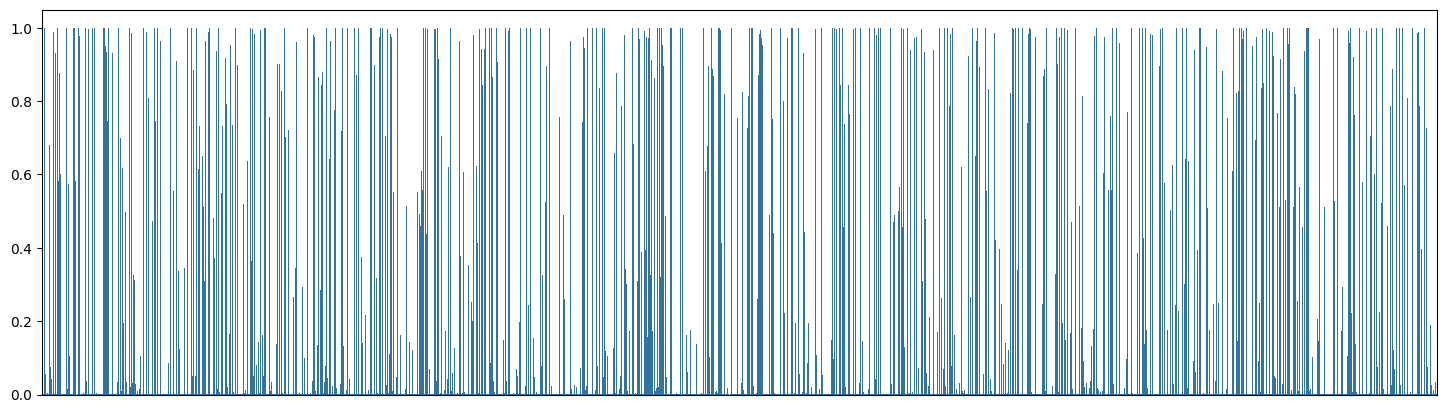

In [ ]:
assert all(models[label]['model'].predict(X) == 0)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

XX = StandardScaler().fit_transform(X)
t = models[label]['model'].predict(XX)
tt = models[label]['model'].predict_proba(XX)[:, 1]

<Axes: >

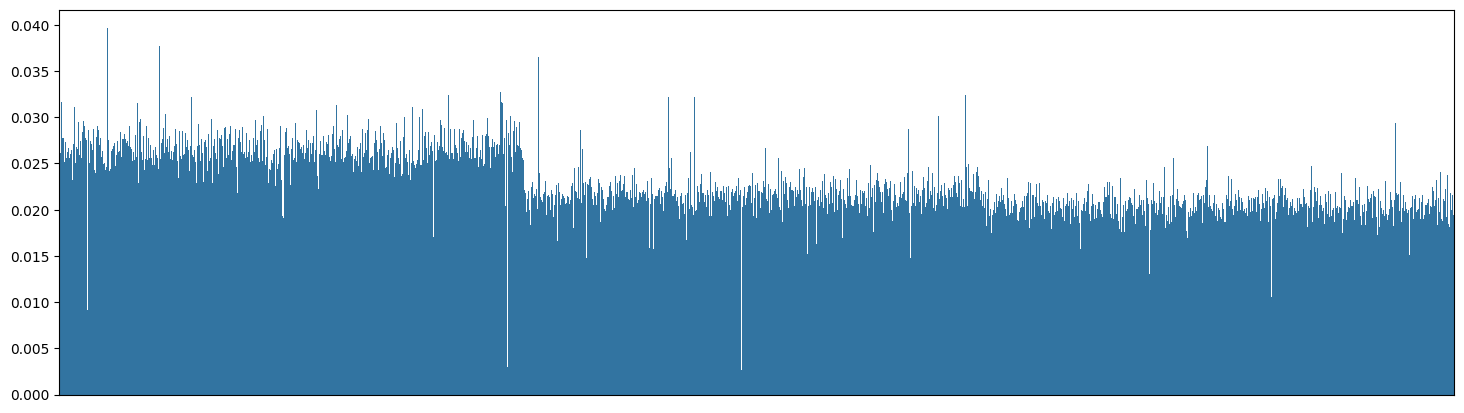

In [134]:
label = 'anger'  # anger, sadness, surprise, disgust, fear
print(models[label]['stats'])


=== Model Performance Statistics ===
Accuracy:  0.8103
Precision: 0.6691
Recall:    0.6964
F1 Score:  0.6825
ROC AUC:   0.8603

Confusion Matrix:
[[812 135]
 [119 273]]

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       947
         1.0       0.67      0.70      0.68       392

    accuracy                           0.81      1339
   macro avg       0.77      0.78      0.77      1339
weighted avg       0.81      0.81      0.81      1339


Test Size: 0.2, Random State: 42
Feature Scaling: Applied
Training Time: 2.2221 seconds



'/Users/thorwhalen/Dropbox/py/proj/misc/infinvest/mood/misc'

In [162]:
import dol

pickle_store = dol.PickleFiles('.')
pickle_store['oa_embeddings_sentiment_models.pickle'] = models

In [ ]:
from oplot.sequences import bars 


<Axes: >

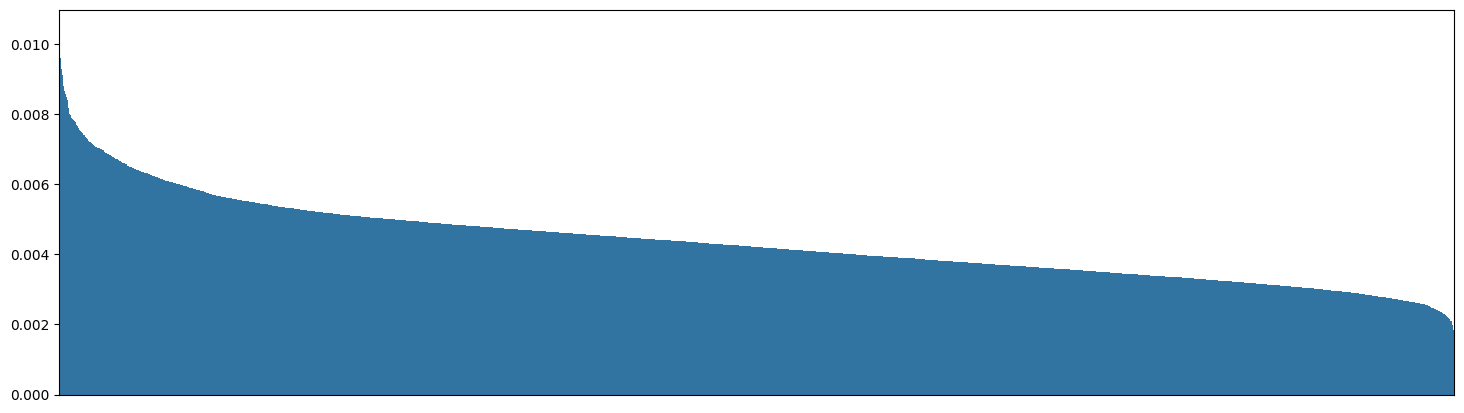

In [117]:
label = 'anger'
t = models[label]['model'].predict_proba(X)[:, 1]
bars(sorted(t, reverse=True))

In [125]:
label = 'anger'
predict_probas = models[label]['model'].predict_proba(X)
predictions = models[label]['model'].predict(X)
all(predictions == 0)

True

<Axes: >

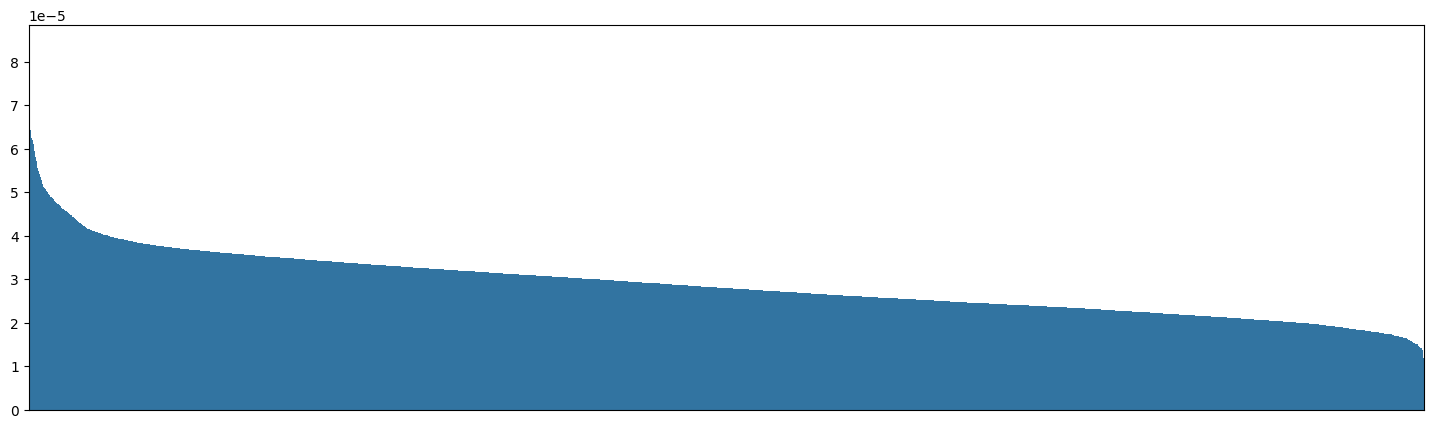

In [118]:
label = 'disgust'
t = models[label]['model'].predict_proba(X)[:, 1]
bars(sorted(t, reverse=True))

In [119]:
X.shape

(6692, 1536)

In [ ]:
model

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:

# # Custom configuration
# model, stats = fit_logistic_classifier(
#     X_embeddings, 
#     y_binary,
#     test_size=0.25,
#     c_value=0.5,
#     solver='saga',
#     penalty='elasticnet',
#     class_weight='balanced',
#     scale_features=True,
#     verbose=True
# )

# # Skip validation and just fit on all data
# model, stats = fit_logistic_classifier(
#     X_embeddings,
#     y_binary,
#     skip_validation=True
# )

# # Make predictions on new data
# new_data_predictions, prediction_probabilities = predict_with_model(
#     model, 
#     new_X, 
#     scaler=StandardScaler().fit(X_embeddings)
# )


## Model sentiment

## sentiment data scrap

In [ ]:
import datasets

import dol 
from functools import partial

base_data = datasets.load_dataset('google-research-datasets/go_emotions')

mapping_extractor = partial(dol.path_get, path='train.features.labels.feature.names', sep='.')
label_mapping = pd.Series(mapping_extractor(base_data))


In [73]:
only_train = False 

if only_train:
    df = go_emotions['train'].to_pandas()
else:
    # concatenate all splits
    df = pd.DataFrame()
    for split in ['train', 'validation', 'test']:
        if split in go_emotions:
            df = pd.concat([df, go_emotions[split].to_pandas()], ignore_index=True)

# rename columns (text -> text, labels -> label)
column_mapping = {'text': 'text', 'labels': 'label'}

df = df.rename(columns=column_mapping)

df.head()

,text,label,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


In [ ]:
from typing import Sequence 
# if the first label is a list, expand any columns that have lists of the same size as their 
# first element into separate rows

# first, figue out if label is a list, and if so, collect all columns that have a list of that 
# size as their first element
list_columns = []
if isinstance(df['label'][0], Sequence):
    first_label_len = len(df['label'][0])
    list_columns = ['label']
    for column in df.columns:
        if len(df[column][0]) == first_label_len:
            list_columns.append(column)

import tabled 

if list_columns:
    df = tabled.expand_rows(df, list_columns)

# reset the index?
reset_index = True
drop = True
if reset_index:
    df = df.reset_index(drop=drop)



In [5]:
import datasets

daily_dialog = datasets.load_dataset('li2017dailydialog/daily_dialog')

label_kind = 'emotion'  # emotion or act
if label_kind == 'emotion':
    mapping_extractor = partial(dol.path_get, path='train.features.emotion.feature.names', sep='.')
elif label_kind == 'act':
    mapping_extractor = partial(dol.path_get, path='train.features.act.feature.names', sep='.')
else:
    raise ValueError(f"Unknown label_kind: {label_kind}")

label_mapping = pd.Series(mapping_extractor(daily_dialog))


#     label_mapping = daily_dialog["train"].features["emotion"].feature.names
# # two kinds of label: emotion and act
# # Retrieve the emotion/sentiment label mapping
# emotion_mapping = daily_dialog["train"].features["emotion"].feature.names
# print(emotion_mapping)

# sentiment_mapping = daily_dialog["train"].features["act"].feature.names  # If 'act' contains dialogue acts
# print(sentiment_mapping)
t = daily_dialog['train'].to_pandas()
t.iloc[0]

dialog     [Say , Jim , how about going for a few beers a...
act                           [3, 4, 2, 2, 2, 3, 4, 1, 3, 4]
emotion                       [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]
Name: 0, dtype: object

In [ ]:
import dol 
from functools import partial

mapping_extractor = partial(dol.path_get, path='train.features.labels.feature.names', sep='.')
go_emotions_label_mapping = pd.Series(mapping_extractor(go_emotions))

0         admiration
1          amusement
2              anger
3          annoyance
4           approval
5             caring
6          confusion
7          curiosity
8             desire
9     disappointment
10       disapproval
11           disgust
12     embarrassment
13        excitement
14              fear
15         gratitude
16             grief
17               joy
18              love
19       nervousness
20          optimism
21             pride
22       realization
23            relief
24           remorse
25           sadness
26          surprise
27           neutral
dtype: object

In [60]:
go_label_mapping

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [ ]:
# Retrieve the emotion/sentiment label mapping
emotion_mapping = daily_dialog["train"].features["emotion"].feature.names
print(emotion_mapping)

sentiment_mapping = daily_dialog["train"].features["act"].feature.names  # If 'act' contains dialogue acts
print(sentiment_mapping)



['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
['__dummy__', 'inform', 'question', 'directive', 'commissive']


In [58]:
print(daily_dialog["train"].features)

{'dialog': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'act': Sequence(feature=ClassLabel(names=['__dummy__', 'inform', 'question', 'directive', 'commissive'], id=None), length=-1, id=None), 'emotion': Sequence(feature=ClassLabel(names=['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'], id=None), length=-1, id=None)}


In [55]:
label_mapping = go_emotions["train"].features["labels"].feature.names
label_mapping

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [20]:
print(f"{list(go_emotions)=}")
print(f"{list(daily_dialog)=}")


list(go_emotions)=['train', 'validation', 'test']
list(daily_dialog)=['train', 'validation', 'test']


In [31]:
kind = 'train'
go = go_emotions[kind].to_pandas()
daily = daily_dialog[kind].to_pandas()
print(f"{kind=}")
print(f"{go.shape=}")
print(f"{go.columns=}")
print(f"{daily.shape=}")
print(f"{daily.columns=}")

kind='train'
go.shape=(43410, 3)
go.columns=Index(['text', 'labels', 'id'], dtype='object')
daily.shape=(11118, 3)
daily.columns=Index(['dialog', 'act', 'emotion'], dtype='object')


In [ ]:
t = go_emotions[kind]
dir(t)

''

In [32]:
go.iloc[0]

text      My favourite food is anything I didn't have to...
labels                                                 [27]
id                                                  eebbqej
Name: 0, dtype: object

In [33]:
daily.iloc[0]

dialog     [Say , Jim , how about going for a few beers a...
act                           [3, 4, 2, 2, 2, 3, 4, 1, 3, 4]
emotion                       [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]
Name: 0, dtype: object

In [35]:
import tabled 

if len(daily) == 11118:
    daily = tabled.expand_rows(daily, ['dialog', 'act', 'emotion'])
print(f"{daily.shape=}")
print(f"{daily.columns=}")

daily.shape=(87170, 3)
daily.columns=Index(['dialog', 'act', 'emotion'], dtype='object')


### Another dataset: empatheticdialogues

In [ ]:
# Note: Need to parametrize to avoid error:
# ParserError: Error tokenizing data. C error: Expected 8 fields in line 2355, saw 10
import tabled 

rootdir = '/Users/thorwhalen/Downloads/empatheticdialogues/'
tables = tabled.DfFiles(rootdir)
list(tables)

# tables['train.csv']

# import pandas as pd 
# import os 

# pd.read_csv(os.path.join(rootdir, 'valid.csv'))

['valid.csv', 'test.csv', 'train.csv']

# search and save news

In [1]:
from mood import search_and_save_news

Making app dir: /Users/thorwhalen/.config/mood
Making app dir: /Users/thorwhalen/.config/scoopy


In [4]:
search_and_save_news(verbose=True)

yahoo_finance_headlines/2025-02-19/2025-02-19--09-52-32__.json


In [ ]:
keyterms= {
    "Profit Warning": "News or announcements indicating that a company expects lower profits than forecasted, often triggering sharp sell-offs.",
    "Earnings Miss": "Reports that actual earnings fell short of expectations, which typically lead to immediate negative price reactions.",
    "Earnings Report": "Company earnings reports that reveal financial performance and shape investor expectations for future growth.",
    "Downgrade": "Analyst downgrades that signal lower future performance and are strongly linked with declines in stock prices.",
    "Merger": "Announcements of mergers that can spark both optimism and uncertainty, influencing investor sentiment and market dynamics.",
    "Acquisition": "News about acquisitions that may alter growth prospects and shift market expectations about future performance.",
    "Bankruptcy": "Reports of bankruptcy filings or imminent financial distress that send strong negative signals to the market.",
    "Default": "Warnings or occurrences of default by companies or sovereign entities, often leading to heightened volatility.",
    "Executive Resignation": "Sudden departures of key executives that may indicate internal problems and prompt market reassessment.",
    "Leadership Change": "Unexpected changes in top management that can be seen as signs of instability or a strategic shift.",
    "Regulatory Change": "Announcements of new or modified regulations that can impact business costs and overall market forecasts.",
    "Trade War": "News of escalating trade disputes or tariffs that disrupt supply chains and create a risk-off environment.",
    "Sanctions": "Government-imposed restrictions that can affect international trade and corporate profitability.",
    "Brexit": "UK-related economic and trade policy changes that impact global markets and European financial stability.",
    "Election Results": "News on election outcomes that influence economic policies, regulation, and investor sentiment.",
    "Geopolitical Tensions": "Conflicts or diplomatic disputes that increase uncertainty and impact global trade and investments.",
    "Black Swan Event": "Unpredictable events (e.g., financial crises, pandemics) that cause extreme market disruption.",
    "Cyberattack": "Reports of major cyberattacks, especially on financial institutions or critical infrastructure, undermining confidence.",
    "Economic Slowdown": "Signals of decelerating economic growth that can lead to lower profit forecasts and bearish market moves.",
    "Recession": "Articles warning of potential economic downturns, signaling broader market risks and shifts in investor sentiment.",
    "Recession Fears": "Increased media and analyst focus on economic downturn risks, which can trigger market anxiety.",
    "Inflation": "Rising inflation news that may force tighter monetary policy, adversely affecting asset prices.",
    "Interest Rates": "Changes in interest rates that impact borrowing costs, corporate profits, and investor sentiment.",
    "Federal Reserve": "Actions or statements from the U.S. central bank that drive monetary policy and market expectations.",
    "GDP Growth": "Economic growth indicators that signal expansion or contraction in economic activity, influencing market movements.",
    "Unemployment Rate": "A key labor market metric that affects consumer spending, corporate earnings, and economic outlook.",
    "Consumer Confidence": "Survey data that reflects consumer sentiment, a leading indicator of economic strength or weakness.",
    "Market Correction": "A significant decline (typically 10% or more) in stock prices, often signaling changing investor sentiment.",
    "Market Volatility": "Reports highlighting spikes in market swings, often a precursor to rapid shifts in investor behavior.",
    "Stock Market Rally": "News of rising stock prices that can indicate optimism or a temporary bounce before further declines.",
    "Bullish/Bearish Sentiment": "Trends in investor confidence that indicate either optimism (bullish) or pessimism (bearish) in the market.",
    "Risk Appetite": "Investor willingness to take on risk, which affects asset allocations and market trends.",
    "Stimulus": "News of fiscal or monetary stimulus measures that tend to boost liquidity and investor optimism.",
    "Litigation": "Reports of significant legal challenges or lawsuits that can materially alter a company's financial outlook.",
    "Supply Chain Disruption": "Information about major disruptions in supply chains—like factory shutdowns or logistics issues—that can hurt earnings.",
    "Scandal": "Mentions of corporate fraud or other scandals that typically lead to swift, negative market reactions.",
    "Oil Prices": "Fluctuations in oil prices that impact inflation, corporate costs, and energy sector performance."
}

In [ ]:
from mood import headlines_mood

current_headlines_mood = headlines_mood()
current_headlines_mood

In [8]:
headline_mood_on_20240623 = {"Yaccarino shakes up X amid Musk's pressure on costs, FT says": -3, 'Coup-hit Niger was betting on a China-backed oil pipeline as a lifeline. Then the troubles began': -7, 'A Mexico City neighborhood keeps the iconic Volkswagen Beetle alive': 1, 'Bitter political fight in Bolivia is paralyzing the government as unrest boils over economic crisis': -8, 'Credit’s Strong Run Stumbles for First Time This Year': -4, 'Former Stark Chairman in Thai Detention After Months on the Run': -5, '2 Millionaire-Maker Technology Stocks': 5, 'Want to Earn More in the Stock Market With Less Effort? Try This Simple Strategy': 4, '3 Reasons to Buy Nvidia Stock Before June 26': 7, "Cathie Wood Says Software Is the Next Big AI Opportunity -- 2 Super Stocks You'll Wish You'd Bought Today if She's Right": 8, 'Companies that give money to Democrats are beating Republican donors in the stock market': 2, 'Is Buying Stocks When the S&P 500 Hits a New All-Time High a Smart Strategy? History Provides a Clear Answer.': 2, 'Q1 Design Software Earnings: Unity (NYSE:U) Earns Top Marks': 4, 'Social Networking Q1 Earnings: Snap (NYSE:SNAP) Simply the Best': 6, "A Look Back at Footwear Stocks' Q1 Earnings: Steven Madden (NASDAQ:SHOO) Vs The Rest Of The Pack": -1, "A Look Back at Heavy Machinery Stocks' Q1 Earnings: Oshkosh (NYSE:OSK) Vs The Rest Of The Pack": -1, 'Unpacking Q1 Earnings: Keurig Dr Pepper (NASDAQ:KDP) In The Context Of Other Beverages and Alcohol Stocks': -2, 'Q1 Earnings Outperformers: Agilysys (NASDAQ:AGYS) And The Rest Of The Vertical Software Stocks': 3, 'What do homebuilders want? Immigration reform': 0, 'Examining the steep rise in monthly auto loan payments': -2, 'Cannes Lions 2024: What marketers are saying': 1, "Sports has to feed into a streamer's 'ecosystem': Kevin Mayer": 0, 'Taylor Swift vs. Central Banks: One Swiftie calls ‘BS’': -2, "'There are bargains out there' as summer travel season heats up": 3, 'This week in Bidenomics: Pile on the debt': -3, 'Netflix flirts with all-time highs as investors cheer ad momentum, foray into live sports': 8, 'Existing home sales decline in May as home prices reach record high': -4, "Regulators find weakness in 'living wills' from BofA, Citi, Goldman, and JPM": -6, 'How to watch and listen to Yahoo Finance': 0, "Why Nvidia's 'gravy train' could come to 'screeching halt' after a volatile trading week": -7, 'Trump’s campaign now has a cash advantage over Biden': 1, 'The Anti-Altman’s Hail Mary Pitch to Investors': -3, "Tesla's Autonomous Strategy to be Key to EV Maker Reaching $1 Trillion-Plus Valuation, Wedbush Says": 7, 'Alaska Airlines, Flight Attendants Union Reach Tentative Deal': 6, 'China’s 618 online shopping event marks first-ever sales drop': -7, 'Apple Throws Down the Gauntlet to European Regulators': -3, 'Apple’s AI Features Won’t Be Offered in European Union Because of New Laws': -5, 'Equity Markets Mostly Lower as Existing Home Sales Drop': -4, 'Oil Rig Count Falls by Three This Week, Baker Hughes Says': -2, 'Dubai Real Estate’s Resilience May Signal End of Boom-Bust Cycle': 5, 'Montana aims to remind seniors about its ‘reverse annuity mortgage’': 0, 'Desmarais-Backed Mortgage Firm Nesto Acquires Lender CMLS': 3, 'Record high prices, rising mortgage rates depress US home sales': -8, 'US home sales fall for the 3rd straight month in May amid rising mortgage rates, record-high prices': -8, "On wealthy Martha's Vineyard, costly housing is forcing workers out and threatening public safety": -7, "Mortgage rates decline for third consecutive week — 'bodes well for the housing market'": 4, 'Congress should adopt mortgage interest tax credit: CHLA': 3, 'Savings interest rates today, June 22, 2024 (best account provides 5.30% APY)': 4, 'How to pay off your house faster with biweekly mortgage payments': 5, 'The best credit cards for vacations for June 2024': 5, "Climate change makes India's monsoons erratic. Can farmers still find a way to prosper?": -2, 'CDK Hackers Want Millions in Ransom to End Car Dealership Outage': -7, 'S&P 500 Trading Volume Spikes at Wall Street Close: Markets Wrap': 0, 'Bitcoin Could Hit $500,000 by October 2025, According to This Billionaire Investor': 7, 'This Is Why Altcoin Investors Struggle Despite Bitcoin, Ether Sitting Near Yearly Highs': -3, 'BitoGroup partners with Far Eastern International Bank to launch first crypto-friendly bank account': 2, 'Cathie Wood sells $13 million of a struggling tech stock': -6, 'Nvidia Stock Gets Hit With Bearish Reversal. If You Have Big Profits, This Is What You Should Do.': -5, "Single Mom With $1.3 Million From Divorce Can't Afford $8,000 Monthly Rent, Dave Ramsey Says It's Time To Move": -6, 'Morningstar | A Weekly Summary of Stock Ideas and Developments in the Companies We Cover': 0, '5 Little-Known Perks of a Costco Membership': 4, 'Billionaire David Tepper Goes Bargain Hunting: 6 Stocks He Just Bought': 5, 'Palantir Inks Deal With Starlab. Is the Stock Ready to Head to the Stars?': 6, "Here's the Average Social Security Benefit at Age 62 -- and Why It's Not the Best News for Retirees": -5, 'Analyst Report: Mitsubishi UFJ Financial Group, Inc.': 0, 'Forget NextEra Energy. Buy This Magnificent Dividend King Instead': 6}
headline_mood_on_20240623

{"Yaccarino shakes up X amid Musk's pressure on costs, FT says": -3,
 'Coup-hit Niger was betting on a China-backed oil pipeline as a lifeline. Then the troubles began': -7,
 'A Mexico City neighborhood keeps the iconic Volkswagen Beetle alive': 1,
 'Bitter political fight in Bolivia is paralyzing the government as unrest boils over economic crisis': -8,
 'Credit’s Strong Run Stumbles for First Time This Year': -4,
 'Former Stark Chairman in Thai Detention After Months on the Run': -5,
 '2 Millionaire-Maker Technology Stocks': 5,
 'Want to Earn More in the Stock Market With Less Effort? Try This Simple Strategy': 4,
 '3 Reasons to Buy Nvidia Stock Before June 26': 7,
 "Cathie Wood Says Software Is the Next Big AI Opportunity -- 2 Super Stocks You'll Wish You'd Bought Today if She's Right": 8,
 'Companies that give money to Democrats are beating Republican donors in the stock market': 2,
 'Is Buying Stocks When the S&P 500 Hits a New All-Time High a Smart Strategy? History Provides a Cl

# Misc

## add_egress

In [5]:
from mood.util import add_egress  # is in i2 and other places

@add_egress(str)
def foo(x: int) -> int:
    return x + 1

assert foo(3) == '4'

# to acccess the underlying function:
underlying_foo = foo.__wrapped__
assert underlying_foo(3) == 4


## Get historical headlines

In [2]:
import requests
from datetime import datetime, timedelta
import os

def headlines_from_newsdata_io(start_date, end_date):
    """Get headlines from NewsData.io within a specified date range."""
    api_key = os.environ['NEWSDATA_API_KEY']
    url = f'https://newsdata.io/api/1/news?apikey={api_key}&q=finance&from_date={start_date}&to_date={end_date}&language=en'

    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to retrieve data")
        return []

    data = response.json()
    headlines = [article['title'] for article in data.get('results', [])]

    return headlines

# Example usage
start_date = '2023-01-01'
end_date = '2023-01-31'
news_data = headlines_from_newsdata_io(start_date, end_date)
if news_data:
    print(f"Fetched {len(news_data)} news headlines from NewsData.io:")
    for headline in news_data:
        print(headline)
else:
    print("No news data fetched.")


Failed to retrieve data
No news data fetched.


In [3]:
import requests
from datetime import datetime

def headlines_from_newsdata_io(api_key, start_date, end_date):
    """Get headlines from NewsData.io within a specified date range."""
    url = f'https://newsdata.io/api/1/news?apikey={api_key}&q=finance&from_date={start_date}&to_date={end_date}&language=en'

    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        print(response.json())
        return []

    data = response.json()
    headlines = [article['title'] for article in data.get('results', [])]

    if not headlines:
        print("No news data found for the specified date range.")
        
    return headlines

# Example usage
api_key = os.environ['NEWSDATA_API_KEY']
start_date = '2023-01-01'
end_date = '2023-01-31'
news_data = headlines_from_newsdata_io(api_key, start_date, end_date)

if news_data:
    print(f"Fetched {len(news_data)} news headlines from NewsData.io:")
    for headline in news_data:
        print(headline)
else:
    print("No news data fetched.")


Failed to retrieve data: 422
{'status': 'error', 'results': {'message': "You can't use the from_date parameter in the news endpoint.", 'code': 'UnsupportedParameter'}}
No news data fetched.


In [5]:
import os
import requests
from datetime import datetime

def headlines_from_newsdata_io(api_key, start_date, end_date):
    """Get headlines from NewsData.io within a specified date range."""
    url = f'https://newsdata.io/api/1/archive?apikey={api_key}&q=finance&from_date={start_date}&to_date={end_date}&language=en'

    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to retrieve data: {response.status_code}")
        try:
            error_data = response.json()
            print("Error details:", error_data)
        except ValueError:
            print("Response content is not valid JSON")
            print(response.text)
        return []

    try:
        data = response.json()
    except ValueError:
        print("Failed to parse response JSON")
        return []

    headlines = [article['title'] for article in data.get('results', [])]

    if not headlines:
        print("No news data found for the specified date range.")
        
    return headlines

# Example usage
api_key = os.environ['NEWSDATA_API_KEY']
start_date = '2023-01-01'
end_date = '2023-01-31'
news_data = headlines_from_newsdata_io(api_key, start_date, end_date)

if news_data:
    print(f"Fetched {len(news_data)} news headlines from NewsData.io:")
    for headline in news_data:
        print(headline)
else:
    print("No news data fetched.")

# Gives me:
# Error details: {'status': 'error', 'results': {'message': 'Access Denied! You need to upgrade your plan in order to access the Archive endpoint.', 'code': 'AccessDenied'}}
# 
# Need to upgrade my plan. The plan to get news Archive API is 150 USD per month. 
# https://newsdata.io/pricing


Failed to retrieve data: 403
Error details: {'status': 'error', 'results': {'message': 'Access Denied! You need to upgrade your plan in order to access the Archive endpoint.', 'code': 'AccessDenied'}}
No news data fetched.


## Sentiment140 (1.6M tweets and sentiment)

See https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

```
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
```

In [2]:
# column names for the kaggle kazanova/sentiment140 dataset
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

In [3]:
from dol import Pipe
import io
import pandas as pd
from operator import methodcaller
from functools import partial

first_item = Pipe(iter, next)
csv_bytes_to_df = Pipe(
    io.BytesIO, partial(pd.read_csv, encoding='latin1', header=None)
)
single_file_zipreader_to_df = Pipe(methodcaller('values'), first_item, csv_bytes_to_df)

### Get the data with haggle (from kaggle)

In [4]:
from haggle import get_kaggle_dataset

kaggle_dataset_slug = 'kazanova/sentiment140'
kaggle_dataset_slug_to_df = Pipe(get_kaggle_dataset, single_file_zipreader_to_df)

In [5]:
df = kaggle_dataset_slug_to_df(kaggle_dataset_slug)
print(f"{df.shape[0]} rows and {df.shape[1]} columns")

1600000 rows and 6 columns


### Get the data from a dropbox link (may not work in th future)

In [30]:
from dol import FilesOfZip
from graze import graze

dropbox_url_to_df = Pipe(graze, FilesOfZip, single_file_zipreader_to_df)

zip_file = 'https://www.dropbox.com/scl/fi/6cadg81efkj0gmzudi2ke/sentiment140.zip?rlkey=40v5hab1gxoc1qbhh01w557cy&dl=1'

df = dropbox_url_to_df(zip_file)


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Poking around

In [6]:
df.columns = column_names
print(f"{df.shape[0]} rows and {df.shape[1]} columns")
print(f"{df.columns=}")

1600000 rows and 6 columns
df.columns=Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [7]:
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [8]:
# data range of the dataset
df['date'].min(), df['date'].max()

('Fri Apr 17 20:30:31 PDT 2009', 'Wed May 27 07:27:38 PDT 2009')

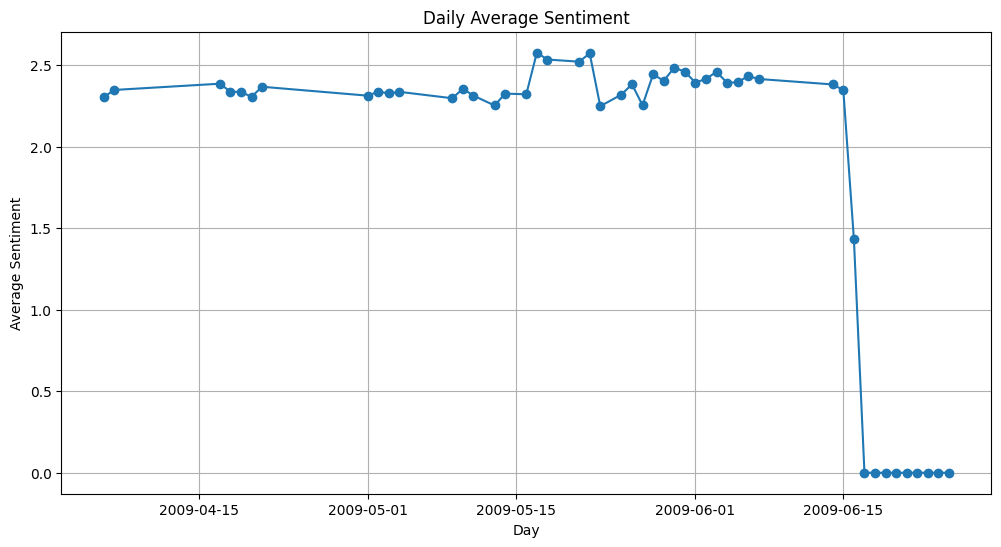

In [15]:
# Make a line graph that shows the average target (i.e. sentiment) every day.
import matplotlib.pyplot as plt
import pandas as pd

# first make a column that has a day value (i.e. without the time)
df['day'] = pd.to_datetime(df['date']).dt.date
daily_avg_sentiment = df.groupby('day')['target'].mean()

plt.figure(figsize=(12, 6))
# make a line plot with o markers
plt.plot(daily_avg_sentiment, marker='o')
plt.title('Daily Average Sentiment')
plt.xlabel('Day')
plt.ylabel('Average Sentiment')
plt.grid()

In [16]:
# from yahoo finance get the stock price of SPY for that period

import yfinance as yf

# get the stock price of SPY for the same period
start_date = df['day'].min()
end_date = df['day'].max()
spy = yf.download('SPY', start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed


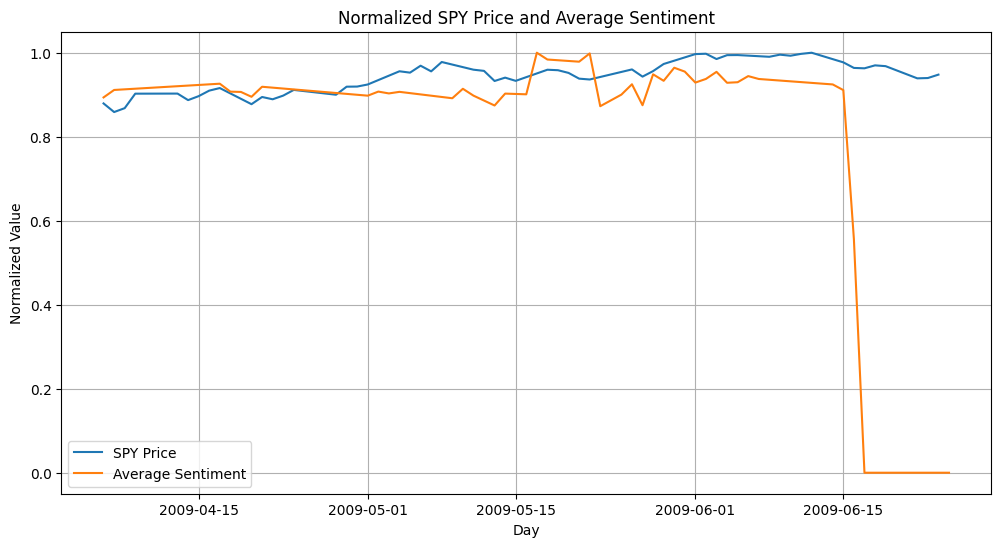

In [18]:
# plot the SPY price and the average sentiment on the same graph
# The plot should be normalized so that the values are on the same scale

plt.figure(figsize=(12, 6))
plt.plot(spy['Close'] / spy['Close'].max(), label='SPY Price')
plt.plot(daily_avg_sentiment / daily_avg_sentiment.max(), label='Average Sentiment')
plt.title('Normalized SPY Price and Average Sentiment')
plt.xlabel('Day')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid()
